Format reference: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html

# **Project Motivation**


* To train some trading strategy based on historical time series, one path is not enough. However, there is only "one" historical (price) path. We need to capture the features of the path and "generate" more synthetic while robust paths to yield a reliable strategy. Note that we must ensure these synthetic paths and the only real path look alike, which means they have similar distributional properties.
* Traditional models focus merely on the distribution of returns, but this viewpoint may not provide a complete picture because the financial world has high-densional distributions. Traditional modelling may be unable to capture such complex distributions. In particular, such a model usually assumes a stationary distribution of the data streams, which is often not the case. Also, the tail events (financial crash) are hard to be modelled.
* Therefore, we turn to **generative adversial networks (GAN)** to capture these high dimensional probability measures.
* Furthermore, we integrate GAN with **signatures**, which extract path feaures to provide a universal description for itself.

## **Outline**

1. Generative Adversatial Network
2. Wasserstein Distance
2. Wasserstein GAN (WGAN)
3. Signature of Paths
4. Sig-Wasserstein GAN (Sig-WGAN)
5. Code Implementation

# **Generative Adversarial Network**

### GAN Overview

A Generative Adversarial Network (GAN) is an artificial neural network architecture used in machine learning and deep learning for generating new data that is similar to existing data. The first GAN was introduced by Ian Goodfellow and his colleagues in 2014 ( https://arxiv.org/abs/1406.2661 ) and have since become a powerful tool in various applications, including image generation, style transfer, super-resolution, and more.

We can summarize Generative Adversarial Networks into 5 components, which are the (1) generator, (2) discriminator, (3) adversial process, (4) loss function, and (5) training process.

These elements will also be visualize below.

**1. Generator**

* The generator is one of the two main components of a GAN.
* It takes random inputs from some distribution (often standard normal), generates new/fake data samples with the inputs. For example, in image generation, the generator takes random noise as input and produces images with this noise vector.
* The generator starts with distributional random noise and gradually learns to generate data that becomes increasingly similar to the real data it's trained on.

**2. Discriminator**

* The discriminator is the second main component of a GAN.
* It evaluates and classifies whether data is "real" (belonging to the actual dataset) or "fake" (generated by the generator).
* The discriminator is trained to improve its ability to distinguish between real and generated data.

**3. Adversarial Process**

* From 1. and 2., it can be noticed that the generator tries to let fake data imitate how real data look, while the discriminator tries to differentiate fake and real data. There is an "adversarial" relationship between the two, hence the name "Generative Adversarial Network."
* This adversarial process leads to a competition where both the generator and discriminator improve over time.

**4. Loss Functions**

* GANs use two loss functions: one for the generator and one for the discriminator.
* The generator's loss encourages it to generate data that fools the discriminator (i.e., the generator wants the discriminator to classify its output as real).
* The discriminator's loss encourages it to correctly classify real and fake data.

**5. Training Process**

* During training, the generator and discriminator are updated one after another.
* The generator produces fake data, which is mixed with real data, and the discriminator is trained on this combined dataset.
* The generator then uses the feedback from the discriminator to improve its output.
* This process continues until the generator creates data that is virtually indistinguishable from real data.

### GAN architecture illustration

Below is a graph of a generative adversarial network (GAN).

In the bottom-left, there is the random vector fed into the **Generator Network**. The generator tries to use this vector to generate *fake data* that is seemingly real. On the other hand, there is *real data* in the top-left of the image.

Both *real* and *fake* data are fed into the **Discriminator Network**, which has real-valued outputs in $[0, 1]$. We should anticipate to see a value close to $1$ if some *real* data is given to the discriminator, and $0$ if some *fake* data is given. This $[0, 1]$ can be interpreted as *the probability that a certain data is real, instead of generated*. Often times, the **sigmoid function**, which has a range of $[0,1]$, is used. 

Notice that whether the output from the discriminator in $[0,1]$ determines how well our GAN is trained. Therefore, the **loss function** will be implemented here to evaluate whether the output in $[0,1]$ is correct. We will return loss functions briefly.

![alt text](./img/notes/GAN.drawio.png "Title")

### Adversarial process illustration

Next, the **adversarial training process** is illustrated. Let us call the green-shaded region "one epoch," which is iterated many times. One epoch is further divided into two phases:

* Phase 1 is where we fix the generator and train the discriminator. In this stage, we train the discriminator to become such that it outputs $0$ when fake (generated) data is given and $1$ when real data is given. In other words, we are encouraging the discriminator to *differentiate* real and fake data.
* Phase 2 fixes the discrimator and trains the generator so that the generator creates fake data that are seemingly real for the discriminator. Precisely, the goal is to generate fake data that the discriminator deems real and outputs $1$.

Notice that, in each epoch, the discriminator is trained $k$ times in phase 1 and the generator is trained only once in phase 2. This will be explained below.

![alt text](./img/notes/AdversarialProcess.png "Title")

### GAN Loss Function

* Discriminator: $D(\mathbf{x}; \theta_d) : \mathcal{X} \rightarrow [0,1]$
* Generator: $G(\mathbf{z}; \theta_g) : \mathcal{Z} \rightarrow \mathcal{X}$
* Two Objectives
    1. Train $D(\mathbf{x}; \theta_d)$ to maximize the probability of assigning the correct label to both real data and $G(\mathbf{z}; \theta_g)$
    $$ \underset{ \theta_d }{\max} \, \bigg\{ \log D(\mathbf{x}; \theta_d) + \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\}$$
    2. Train $G(\mathbf{z}; \theta_g)$ to fool 
    $D(\cdot)$, i.e. maximizing $D(G(\mathbf{z}))$. This is equivalent to minimizing the inverse probability:
    $$ \underset{ \theta_g }{\min} \, \bigg\{ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\} $$
    3. Combine these two objectives:
    $$ V(G,D) := \underset{ \theta_g }{\min} \, \underset{ \theta_d }{\max} \, \bigg\{ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }\bigg[ \log D(\mathbf{x}; \theta_d) \bigg] + \underset{ \mathbf{z} \in \mathcal{Z} }{ \mathbb{E} }\bigg[ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg] \bigg\} $$

To understand the **loss function** of GANs, let's return to [Goodfellow's orginal paper](https://arxiv.org/abs/1406.2661). 

Let $\mathcal{X}$ be the space real data is on and $\mathcal{Z}$ be the latent space the generator uses an input. The real data has a distribution $p_{\textrm{real}}$ over $\mathcal{X}$, and the generator has a distribution $p_g$ over $\mathcal{X}$.

Let $D(\mathbf{x}; \theta_d)$ denote the discriminator with parameters $\theta_d$ and $G(\mathbf{z}; \theta_g)$ denote the generator with parameters $\theta_g$. The generator maps the latent space to the real data space, i.e. $G(\mathbf{z}; \theta_g) = \mathbf{x}_g \in \mathcal{X}$ with $\mathbf{x}_g \sim p_g$. We can interpret $D(\mathbf{x}; \theta_d)$ as the probability that $\mathbf{x}$ came from the data ( $p_{\textrm{real}}$ ) rather than the generated data ( $p_g$ ). Therefore, $D: \mathcal{X} \rightarrow [0,1] \subset \mathbb{R}$.

Our quest for the **discriminator** is, as said in [the orginal paper](https://arxiv.org/abs/1406.2661), *training $D(\mathbf{x}; \theta_d)$ to maximize the probability of assigning the correct label to both training examples and samples from $G(\mathbf{z}; \theta_g)$*. This can be formalized as:

$$ \underset{ \theta_d }{\max} \, \bigg\{ \log D(\mathbf{x}; \theta_d) + \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\} \quad \textrm{ where } \mathbf{x} \sim p_{\textrm{real}} \, , \, \mathbf{z} \in \mathcal{Z} \, , \, G(\mathbf{z}) = \mathbf{x}_g \sim p_g$$

On the other hand, the **generator** attempts to fool the discriminator. Therefore, it should seek to maximize $D(G(\mathbf{z}))$, making the output close to $1$. Alternatively, it seeks to minimize the inverse probability from the discriminator:

$$ \underset{ \theta_g }{\min} \, \bigg\{ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg\} $$

Combining both objectives, we have a two-player minimax game with value function $V(G,D)$:

$$ V(G,D) := \underset{ \theta_g }{\min} \, \underset{ \theta_d }{\max} \, \bigg\{ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }\bigg[ \log D(\mathbf{x}; \theta_d) \bigg] + \underset{ \mathbf{z} \in \mathcal{Z} }{ \mathbb{E} }\bigg[ \log \big[ \, 1 - D(G(\mathbf{z}; \theta_g); \theta_d) \, \big] \bigg] \bigg\} $$

Lastly, an iterative and numerical approach is taken to implement this game. "*To avoid prohibitive computation and overfitting, each epoch of GAN alternates between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in $D$ being maintained near its optimal solution, so long as $G$ changes slowly enough.*"


### GAN Pseudocode

The pseudocode for each epoch is as follows:

1. Loop $k$ times (Train the discriminator $k$ many times.)
    1. Randomly sample a batch of latent data $\{ \mathbf{z}^{(1)}, \cdots , \mathbf{z}^{(m)} \} \subset \mathcal{Z}$ and a batch of real data $\{ \mathbf{x}_{\textrm{real}}^{(1)}, \cdots , \mathbf{x}_{\textrm{real}}^{(m)} \} \subset \mathcal{X}$ such that $\mathbf{x}_{\textrm{real}}^{(i)} \sim p_{\textrm{real}}$.
    2. Update the discriminator $D$ by **ascending** the gradient of $V(G,D)$ w.r.t. $\theta_d$:
    $$ { \nabla }_{ \theta_d } \, \frac{1}{m} \sum_{i=1}^{m} \bigg\{ \log D(\mathbf{x}_{\textrm{real}}^{(i)}; \theta_d) + \log \big[ \, 1 - D(G(\mathbf{z}^{(i)}; \theta_g); \theta_d) \, \big] \bigg\} $$
    * This gradient makes $D$ better at differentiating $\mathbf{x}_{\textrm{real}}$ from $\mathbf{x}_g$. Note that $\theta_g$ is fixed here.
2. Randomly sample a new batch of latent data $\{ \mathbf{z}^{(1)}, \cdots , \mathbf{z}^{(m)} \} \subset \mathcal{Z}$.
3. Update the generator $G$ by **descending** the gradient of $V(G,D)$ w.r.t. $\theta_g$:
$$ { \nabla }_{ \theta_g } \, \frac{1}{m} \sum_{i=1}^{m} \bigg\{ \log \big[ \, 1 - D(G(\mathbf{z}^{(i)}; \theta_g); \theta_d) \, \big] \bigg\} $$
* This gradient makes $G$ better at fooling the discriminator $D$. Note that $\theta_d$ is fixed here

This epoch is iterated until training is completed. Notice that there is one gradient ascent and one gradient descent. This is due to the minimax nature of our game.

# **Wasserstein Distance**

### Why do we need Wasserstein Distance?

After the publication of GAN, several difficulties arise when training GANs. The paper, [Towards Principled Methods for Training Generative Adversarial Networks](https://arxiv.org/abs/1701.04862), gave theoretical explanations on GAN's inherent problems. Below I list them briefly.

* Thm 2.4 - The better the discriminator gets, the more the gradients of generators vanish. Without gradients, it's effectively hard to train.
* Thm 2.5 - Minimizing the loss in generator is equivalent to minimizing a weird distributional metric. This leads to **mode collapsing**, which means the variety in data that the generator can create is lacking. For example, there are 10 types of data in the famous MNIST dataset, which contains handwritten digits of 0~9. If our the model collapses in our generator, it may only generate one single digit.
* Thm 2.6 - Generator gradients are instable.

### What is the Wasserstein Distance?

* Given two distributions $p(x)$ and $q(y)$ for $x, y \in \mathcal{X}$.
* Joint distribution $\pi(x,y)$ satisfies $\int_y \pi(x,y) dy = p(x)$ and $\int_x \pi(x,y) dx = q(y)$
* Wasserstein Distance:
$$ W(p,q) := \underset{ \pi }{ \inf } \left( \int_{ \mathcal{X} \times \mathcal{X} } || x-y || \, \pi(x,y) \, dx \, dy \right) = \underset{ \pi }{ \inf } \underset{ (x,y) \sim \pi }{ \mathbb{E} }  \big[ || x-y || \big] $$

Given two distributions $p(x)$ and $q(y)$ for $x, y \in \mathcal{X}$, the Wasserstein Distance gives us a way to know how similar the two distributions are. Let $\pi(x,y)$ be a joint distribution of $\mathcal{X} \times \mathcal{X}$ that satisfies $\int_y \pi(x,y) dy = p(x)$ and $\int_x \pi(x,y) dx = q(y)$. The Wasserstein Distance is defined by:

$$ W(p,q) := \underset{ \pi }{ \inf } \left( \int_{ \mathcal{X} \times \mathcal{X} } || x-y || \, \pi(x,y) \, dx \, dy \right) = \underset{ \pi }{ \inf } \underset{ (x,y) \sim \pi }{ \mathbb{E} }  \big[ || x-y || \big] $$

The *optimal transport problem* in the figure below helps clarify the idea concretely. In short, we want to know the *least effort* required to move some pile of stuff with distribution $p(\cdot)$ to another pile with distribution $q(\cdot)$.

![alt text](./img/notes/transport_problem.png "Title")

Then, $\pi(x,y)$ tells how much mass is moved from $x$ to $y$. If we multiply this mass by the distance it moved, $||x-y||$, the value $||x-y|| \, \pi(x,y)$ is the effort for this single transport. By adding them up or integrating, we have the total effort. Taking $\inf_\pi$ means we look for a plan, $\pi$, that minimizes our total effort, which is what **Wasserstein Distance** tries to capture.

# **Wasserstein GAN (WGAN)**

### Original WGAN

An important result for the Wasserstein Distance is the **Kantorovich-Rubinstein Duality**, which makes the Wasserstein GAN (WGAN) optimization much easier to deal with. The Kantorovich-Rubinstein Duality states:

$$ W(p,q) = \underset{ \pi }{ \inf } \underset{ (x,y) \sim \pi }{ \mathbb{E} }  \big[ || x-y || \big] = \underset{ h \textrm{ is 1-Lipshitz} }{ \sup } \bigg[ \underset{ x \sim p }{ \mathbb{E} }  \big[ h(x) \big] - \underset{ y \sim q }{ \mathbb{E} }  \big[ h(y) \big] \bigg] $$

In laymans' terms, the optimal transport problem becomes finding some $1$-Lipschitz function that maximizes the difference between real and fake data. Applying this result, the value function of the minimax game in GAN becomes finding a $1$-Lipschitz discriminator:

$$ V(G,D) = \underset{ D \textrm{ is 1-Lipshitz} }{ \sup }  \bigg[ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ D(\mathbf{x}; \theta_d) \big] - \underset{ \mathbf{z} \in \mathcal{Z} }{ \mathbb{E} }  \big[ D(G(\mathbf{z}; \theta_g); \theta_d) \big] \bigg] $$

Below is the implementation of Wasserstein GAN (WGAN) in the paper [Wasserstein GAN](https://arxiv.org/abs/1701.07875). The discriminator is renamed as *critic* in WGAN.

![alt text](./img/notes/WGAN_algo.jpg "WGAN_algo")

**Notes**
* Line 6: We're taking gradient "ascent" to maximize the Wasserstein distance between real and fake data.
* Line 7: the weight ( $\theta_d$ ) is clipped by some constant because we need the critic/discriminator to be $K$-Lipschitz ($K=1$). Recall that a function $f$ is $K$-Lipschitz when: $||f(\mathbf{x}_1) - f(\mathbf{x}_2)|| \le K ||\mathbf{x}_1 - \mathbf{x}_2||$ for any $x_1,x_2 \in \mathcal{X}$ or $\frac{\partial f}{\partial \mathbf{x}} \le K$ .
* Line 10: We're taking gradient "descent" to encourage the generator to generate fake data that are seemingly real.

### WGAN with gradient penalty

Quote from the [WGAN paper](https://arxiv.org/1701.07875): *Weight clipping is a clearly terrible way to enforce a Lipschitz constraint.* Either having a too large or too small clipping parameter leads to bad performance. The paper [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028) provides an alternative that also satisfies the $1$-Lipschitz condition by [1] interpolating real and fake data (line 6 below) and [2] penalizing the critic loss (line 7 below). The entire pseudocode is:

![alt text](./img/notes/WGAN_GP_algo.jpg "WGAN_algo")

Reference to be read:
* Duality Proofs
    * https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FH1pT3o2Br
    * https://zhuanlan.zhihu.com/p/366796145
* Why W-GAN?: https://zhuanlan.zhihu.com/p/25071913
* Others
    * https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
    * https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

# **Signature Transform of Paths**

The **signature transform** is a mathematical technique used to extract information from paths or sequences of data. It is particularly useful in the field of rough path theory, which has applications in various areas, including stochastic analysis, machine learning, and finance.

The signature transform is based on the concept of *iterated integrals of a path or sequence*. Here's a brief overview of how it works:

1. **Input some Paths or Sequences**: Consider a path or sequence of data points, often represented as a continuous curve or a discrete sequence of values.

2. **Compute Iterated Integrals**: The signature transform involves computing iterated integrals of the path. The integrals go from a simple integration, double integration, triple integration, all the way up to infintely-many-times iterated integration. These integrals capture information about the path's curvature and the relationships between different parts of the path.

3. **Organize the Integrals into a Tensor Structure**: The computed iterated integrals are organized into a tensor-like structure, where each component of the tensor corresponds to a particular level of integration. The order of integration determines the rank of the tensor.

4. **Features Extraction**: The resulting tensor structure, known as the path signature, contains information about the original path's shape, direction, and higher-order properties. It can be used as a feature vector for further analysis or classification tasks.

The signature transform is valuable in applications involving sequential data, such as time series analysis or handwriting recognition. By encoding the path's information into a structured tensor, it allows for effective and efficient analysis while maintaining information about the entire path, including higher-order interactions between data points.

Let us formulate the signature of a path mathematically.

Given a continuous $d$-dimensional path $X : [a,b] \to \mathbb{R}^d$ with $X(t) =: X_t = (X^1_t, \ldots, X^d_t )$, the *signature* is denoted by $S(X)_{a,b} \in T(\mathbb{R}^d)$, where $T(\mathbb{R}^d)$ is the tensor algebra space.

$$ S(X)_{a,b} := ( 1, S(X)^{1}_{a,b}, \cdots, S(X)^{d}_{a,b},  S(X)^{1,1}_{a,b}, \cdots,  S(X)^{d,d}_{a,b},  S(X)^{1,1,1}_{a,b}, \cdots ) $$

where, for $I=(i_1,\cdots,i_n)$ with $i_k$, $i_l$ not necessarily distinct and size $|I|$ not bounded above,

$$ S(X)^{I}_{a,b} = \underset{\substack{ a < u_1 < u_2 < \ldots < u_n < b }}{\int\ldots\int} d X_{u_1}^{i_1} \cdots d X_{u_n}^{i_n} $$

There are $d$ first order signatures. Each component is the change in the $i$-th dimensional of the path:
$$ S(X)^{i}_{a,b} = \underset{\substack{ a < u < b }}{\int} d X_{u}^{i} = X_{b}^{i} - X_{a}^{i} $$

There are $d^2$ second order signatures. The second order signatures look like:
$$ S(X)^{i_1,i_2}_{a,b} = \underset{\substack{ a < u_1 < u_2 < b }}{\int \int} d X_{u_1}^{i_1} d X_{u_2}^{i_2} = \underset{\substack{ a < u_2 < b }}{\int} S(X)^{i_1}_{a,u_2} d X_{u_2}^{i_2} $$

Continue inductively, we would have $d^k$ many signatures of order $k$, and they would be:
$$ S(X)^{i_1, \ldots, i_k}_{a, b} := \int_a^b S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k } \, dX^{i_k}_{u_k} $$

Notice that for order-$k$ with $k \ge 2$, the signatures are effectively integrating the area under the curves of the order-$(k-1)$ signature, $S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k}$.

### Truncated Signatures

Finally, in the examples below we would notice the latter terms of a signature diminishes to zero quickly, so loosely speaking we could *truncate* the terms up till the $M$-th order (The terms with $|I| \le M$). Although signatures are as if infinite dimensional, the truncated ones are more managable:

$$  S(X)_{a,b}^{(M)} := ( 1, S(X)^{1}_{a,b} \, , \cdots , S(X)^{d,\cdots,d}_{a,b} ) $$

### Numerical Implementation
Below is a numerical implementation of the signature method on a path. I used computed signatures of 5 linear paths in help understand how different paths affect the signatures.

The paths are:
1. $X_t = (t,2t)$
2. $X_t = (t,t)$
3. $X_t = (t,0)$
4. $X_t = (t,-t)$
5. $X_t = (t,-2t)$

The function `compute_signature()` computes the signature of paths by using the iterative formula $ S(X)^{i_1, \ldots, i_k}_{a, b} := \int_a^b S(X)^{i_1, \ldots, i_{k-1}}_{a, u_k } \, dX^{i_k}_{u_k} $ from above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import math

import signatory
import torch

In [2]:
def compute_signature(path_nd: np.ndarray, turncate_order: int = 3):

    permutation_elements = [i for i in range(0, path_nd.shape[-1])]
    path_nd_diff = np.diff(path_nd, axis=0)

    signatures_up_to_order_k = []
    previous_permutation_list = None

    for k in range(1, turncate_order+1):
        order_k_signatures = [ ]
        permutation_list = list(itertools.product(permutation_elements, repeat=k))

        for indices in permutation_list:
            # print(f"order {k} index {indices}")
            if k == 1:
                signature_up_to_u = np.cumsum( path_nd_diff[...,indices], axis=0 )
                # print(signature_up_to_u)
            elif k >= 2:
                # continue
                prev_indices = previous_permutation_list.index( indices[:-1] )
                prev_signature = signatures_up_to_order_k[k-2][prev_indices]
                # print( prev_signature )
                # print( path_nd_diff[ ... , indices[-1] ] )
                tensor_prod = np.multiply( prev_signature, path_nd_diff[ ... , indices[-1] ].reshape( path_nd_diff.shape[0], -1) )
                # print( tensor_prod )
                signature_up_to_u = np.cumsum( tensor_prod, axis=0 )
                # print( signature_up_to_u )

            order_k_signatures.append( signature_up_to_u )

        signatures_up_to_order_k.append( order_k_signatures )
        previous_permutation_list = permutation_list

    return signatures_up_to_order_k

In [116]:
# signature_2d = compute_signature( path_2d, turncate_order=3 )
# signature_3d = compute_signature( path_3d, turncate_order=3 )

Lastly, plot the signatures as below:

In [3]:
def plot_paths_and_signatures(paths, signatures, order,
        path_lim: tuple = (-2,2), sig_lim: tuple = (-2,2)
    ):
    last_signatures = []
    tick_labels = []
    for i in range( len(paths) ):
        last_signature = []
        tick_label = []

        for k in range(1,order+1):
            permutation_elements = [j for j in range(paths[i].shape[-1])]
            permutation_list = list(itertools.product(permutation_elements, repeat=k))
            for l, sig in enumerate(signatures[i][k-1]):
                # print(permutation_list[l], sig[-1])
                last_signature.append( sig[-1][0] )  # get value at the last time index
                tick_label.append( permutation_list[l] )
        
        last_signatures.append( last_signature )
        tick_labels.append( tick_label )

    num_paths = len(paths)
    num_characteristics = len(tick_labels)

    # Create a figure with subplots
    each_height = 2**order*0.5
    fig, axes = plt.subplots(num_paths, 2, figsize=(8, 0.7*num_paths*each_height), gridspec_kw={'width_ratios': [3, 2]})

    min_value = -2
    max_value = 2
    norm = plt.Normalize(min_value, max_value)
    cmap = cm.get_cmap('viridis')

    for i, path in enumerate(paths):
        # Plot the paths in the left column
        axes[i, 0].set_ylim( path_lim )
        axes[i, 0].plot(path[:,0], path[:,1], label=f'Path {i+1}')
        axes[i, 0].set_xlabel(f'Path {i+1} : $x$')
        axes[i, 0].set_ylabel(f'Path {i+1} : $y$')
        axes[i, 0].grid(True)

        # Plot the Signatures in the right column
        axes[i, 1].set_xlim( sig_lim )
        axes[i, 1].barh( [str(x) for x in tick_labels[i]], last_signatures[i], color=cmap(norm(last_signatures[i])))
        axes[i, 1].set_xlabel('Signature Value')
        axes[i, 1].grid(True)


    # Adjust spacing between subplots for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

def signature_numerical_display(path, signature, order):
    last_signature = []
    tick_label = []
    for k in range(1,order+1):
        permutation_elements = [i for i in range(path.shape[-1])]
        permutation_list = list(itertools.product(permutation_elements, repeat=k))
        for l, sig in enumerate(signature[k-1]):
            # print(permutation_list[l], sig[-1])
            last_signature.append( sig[-1][0] )  # get value at the last time index
            tick_label.append( permutation_list[l] )
    
    return last_signature

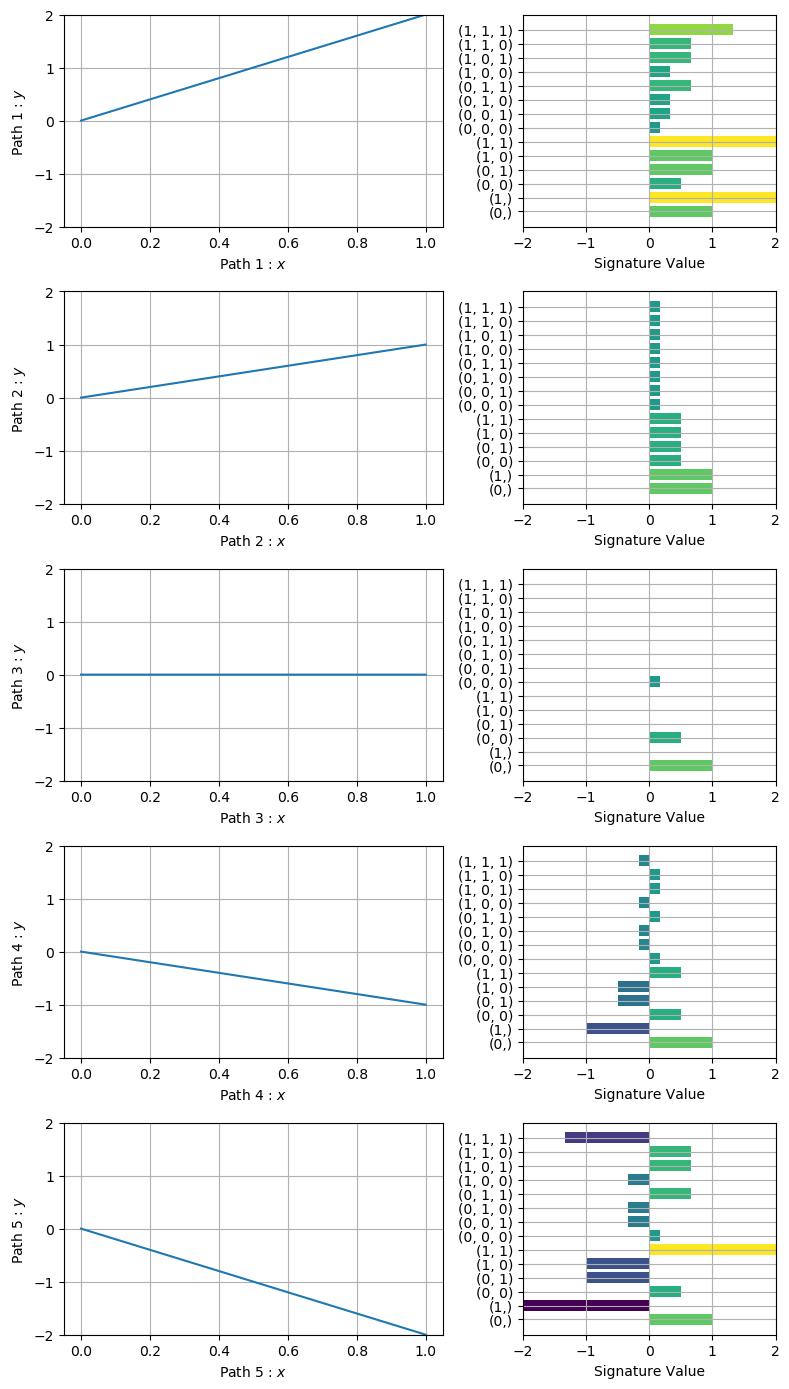

In [4]:
a, b, steps = 0, 1, 10**4+1
t = np.linspace(a, b, steps)

def path_linear_function(t, intercept, slope):
    # return t, t**2 
    return t, intercept + slope*t

path_2d_1 = np.array([path_linear_function(ti, 0,  2) for ti in t])
path_2d_2 = np.array([path_linear_function(ti, 0,  1) for ti in t])
path_2d_3 = np.array([path_linear_function(ti, 0,  0) for ti in t])
path_2d_4 = np.array([path_linear_function(ti, 0, -1) for ti in t])
path_2d_5 = np.array([path_linear_function(ti, 0, -2) for ti in t])

order = 3

s1 = compute_signature( path_2d_1, turncate_order=order )
s2 = compute_signature( path_2d_2, turncate_order=order )
s3 = compute_signature( path_2d_3, turncate_order=order )
s4 = compute_signature( path_2d_4, turncate_order=order )
s5 = compute_signature( path_2d_5, turncate_order=order )

paths = [path_2d_1, path_2d_2, path_2d_3, path_2d_4, path_2d_5]
signatures = [s1,s2,s3,s4,s5]

plot_paths_and_signatures(paths, signatures, order)

Compare the implementation above and the `signatory.signature` package:

In [5]:
torch.tensor( signature_numerical_display(path_2d_1, s1, order) )

tensor([1.0000, 2.0000, 0.5000, 1.0001, 1.0001, 2.0002, 0.1667, 0.3334, 0.3334,
        0.6669, 0.3334, 0.6669, 0.6669, 1.3337], dtype=torch.float64)

In [6]:
signatory.signature( torch.from_numpy(path_2d_1[None,...]), order )

tensor([[1.0000, 2.0000, 0.5000, 1.0000, 1.0000, 2.0000, 0.1667, 0.3333, 0.3333,
         0.6667, 0.3333, 0.6667, 0.6667, 1.3333]], dtype=torch.float64)

The graph on the left column plots the path itself. The righter column shows the values of the signatures, with the indices $(i_1,\cdots,i_k)$ of $S(X)^{i_1, \ldots, i_k}_{a, b}$ on the vertice axes. Notice that the signatures reflects the slope of the path.

### Important Properties of Signatures

#### Translation Invariance

The path integrals are invariant with respect to $X_t$ in $\int_a^b Y_u dX_u$. I.e. shifting a path makes no difference in their corresponding signature.

More precisely,  define $Z_t = X_t + c$ with some constant $c \in \mathbb{R}$. We have
$$ \int_a^b Y_t \, dX_t = \int_a^b Y_t \, dZ_t $$

This can be seen the two paths below, which are
1. $X_t = (t, t^2)$
2. $X_t = (t, t^2 - 1)$

for $t \in [-1,1]$.

The two paths below are indeed parallel shifts from the other, and it is clear that their signatures are identical.

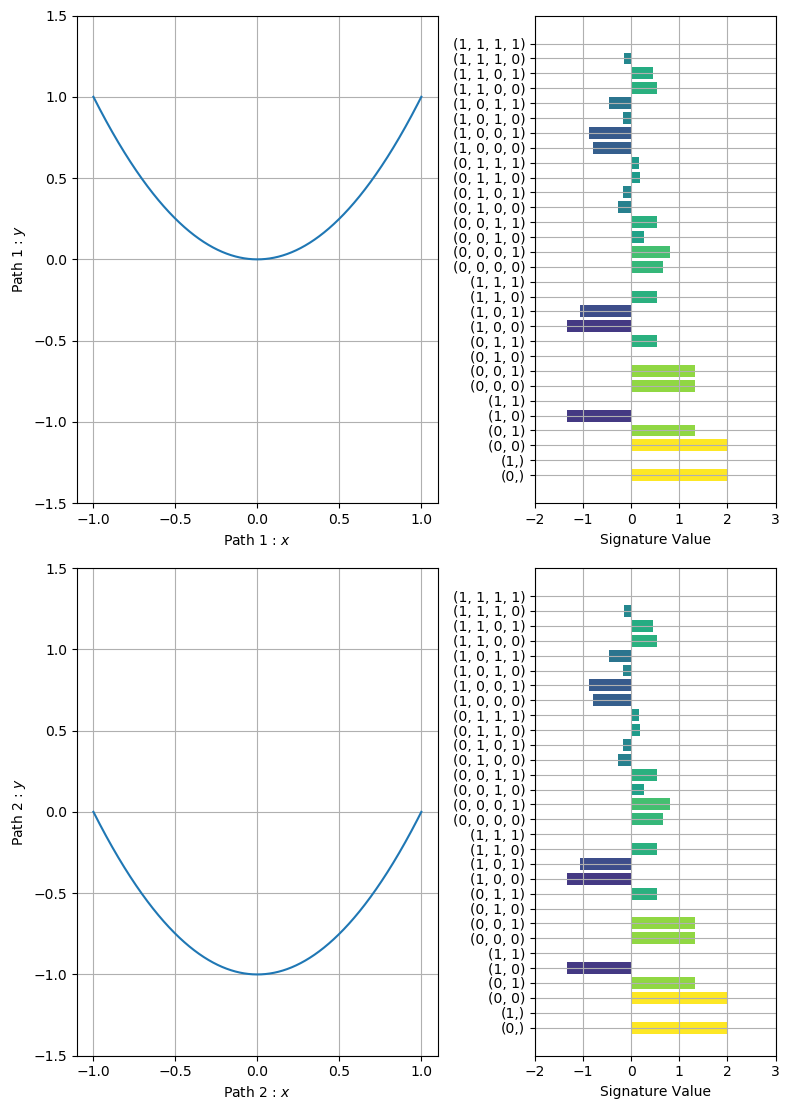

In [10]:
a, b, steps = -1, 1, 2*10**4+1
t = np.linspace(a, b, steps)
order = 4

p23 = np.array([ (ti,ti**2) for ti in t])
p24 = np.array([ (ti,ti**2-1) for ti in t])

s23 = compute_signature( p23, turncate_order=order )
s24 = compute_signature( p24, turncate_order=order )

paths = [p23,p24]
signatures = [s23,s24]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-1.5,1.5), sig_lim=(-2,3))

#### Reparametrization Invariance


The signatures are infact invariant with respect to $t$ in $\int_a^b Y_t \, dX_t$. In other words, the signature is not affected the speed of the path.

For example, the signature of a hand-written number of a piece of paper is always the same, no matter how fast it is written down.

Below is an example where the shapes of the two paths are the same, while their speeds with respect to time $t$ are different. The paths are:

* $X_t = ( \, \sin(2t) \, , \cos(2t) \, )$ for $t \in [0,\frac{\pi}{2}]$
* $X_t = ( \, \sin(t) \, , \cos(t) \, )$ for $t \in [0,\pi]$

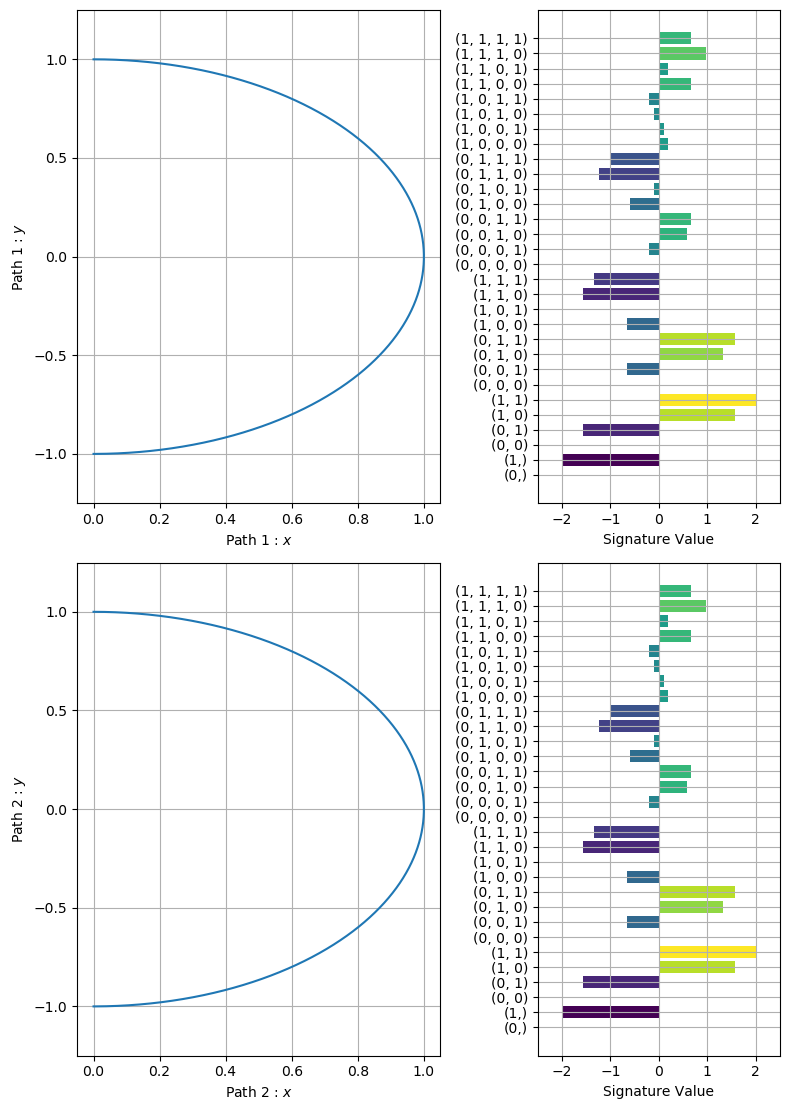

In [27]:
a, b, steps = 0, math.pi/2, 4*10**4+1
t = np.linspace(a, b, steps)

p1 = np.array([(np.sin(2*ti), np.cos(2*ti)) for ti in t])

a, b, steps = 0, math.pi, 4*10**4+1
t = np.linspace(a, b, steps)

p2 = np.array([(np.sin(ti), np.cos(ti)) for ti in t])

order = 4

s1 = compute_signature( p1, turncate_order=order )
s2 = compute_signature( p2, turncate_order=order )

paths = [p1, p2]
signatures = [s1,s2]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-1.25,1.25), sig_lim=(-2.5,2.5))

In [24]:
torch.tensor( signature_numerical_display(p1, s1, order) )

tensor([ 1.5927e-03, -2.0000e+00,  6.2860e-05, -1.5708e+00,  1.5676e+00,
         2.0001e+00,  9.8770e-08, -6.6673e-01,  1.3308e+00,  1.5709e+00,
        -6.6423e-01,  1.9896e-06, -1.5677e+00, -1.3335e+00,  1.9753e-09,
        -1.9640e-01,  5.8804e-01,  6.6676e-01, -5.8698e-01, -9.9631e-02,
        -1.2313e+00, -9.8187e-01,  1.9534e-01,  9.9663e-02, -9.9633e-02,
        -1.9638e-01,  6.6426e-01,  1.9638e-01,  9.7975e-01,  6.6679e-01],
       dtype=torch.float64)

In [23]:
signatory.signature( torch.from_numpy(p1[None,...]), order )

tensor([[ 1.5927e-03, -2.0000e+00,  1.2683e-06, -1.5708e+00,  1.5676e+00,
          2.0000e+00,  6.7331e-10, -6.6667e-01,  1.3308e+00,  1.5708e+00,
         -6.6417e-01,  1.9895e-06, -1.5676e+00, -1.3333e+00,  2.6809e-13,
         -1.9635e-01,  5.8799e-01,  6.6667e-01, -5.8693e-01, -9.9631e-02,
         -1.2312e+00, -9.8175e-01,  1.9529e-01,  9.9632e-02, -9.9633e-02,
         -1.9635e-01,  6.6417e-01,  1.9635e-01,  9.7962e-01,  6.6666e-01]],
       dtype=torch.float64)

Try additional paths and truncate their signatures to order $3$:
1. $X_t = (t,t^2)$
2. $X_s = (s,1-(s-1)^2)$

We can define a surjective map $f:t \mapsto s$ by $f(t)=1 + \sqrt{1-t^2} = s$. Clearly their signatures are identical.

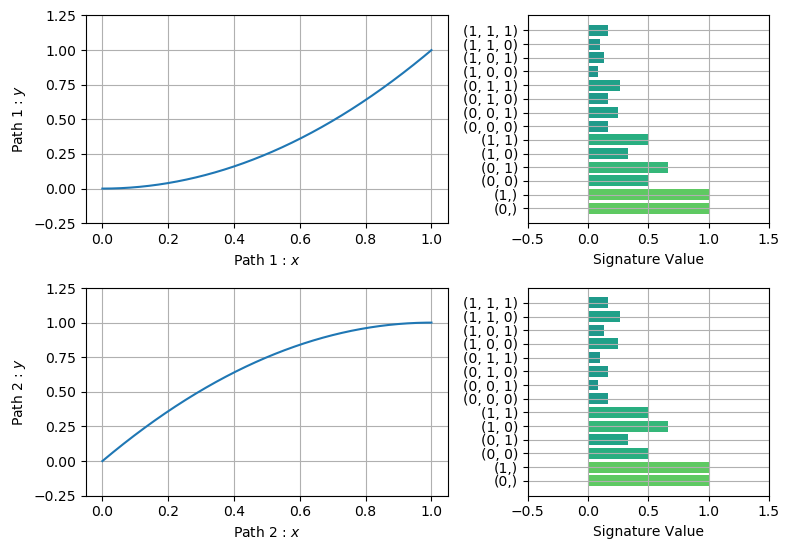

In [7]:
a, b, steps = 0, 1, 10**4+1
t = np.linspace(a, b, steps)

p21 = np.array([ (ti,ti**2) for ti in t])
p22 = np.array([ (ti, 1-(ti-1)**2) for ti in t])

order = 3

s21 = compute_signature( p21, turncate_order=order )
s22 = compute_signature( p22, turncate_order=order )

paths = [p21,p22]
signatures = [s21,s22]

plot_paths_and_signatures(paths, signatures, order, path_lim=(-0.25,1.25), sig_lim=(-0.5,1.5))

In [13]:
torch.tensor( signature_numerical_display(p21, s21, order) ), signatory.signature( torch.from_numpy(p21[None,...]), order )

(tensor([1.0000, 1.0000, 0.5000, 0.6667, 0.3334, 0.5001, 0.1667, 0.2501, 0.1667,
         0.2667, 0.0834, 0.1334, 0.1000, 0.1667], dtype=torch.float64),
 tensor([[1.0000, 1.0000, 0.5000, 0.6667, 0.3333, 0.5000, 0.1667, 0.2500, 0.1667,
          0.2667, 0.0833, 0.1333, 0.1000, 0.1667]], dtype=torch.float64))

In [12]:
torch.tensor( signature_numerical_display(p22, s22, order) ), signatory.signature( torch.from_numpy(p22[None,...]), order )

(tensor([1.0000, 1.0000, 0.5000, 0.3334, 0.6667, 0.5001, 0.1667, 0.0834, 0.1667,
         0.1000, 0.2501, 0.1334, 0.2667, 0.1667], dtype=torch.float64),
 tensor([[1.0000, 1.0000, 0.5000, 0.3333, 0.6667, 0.5000, 0.1667, 0.0833, 0.1667,
          0.1000, 0.2500, 0.1333, 0.2667, 0.1667]], dtype=torch.float64))

In [18]:
a, b, steps = 0, 1, 10**4+1
t = np.linspace(a, b, steps)

p21 = np.array([ (ti) for ti in t])
p22 = np.array([ (math.sin( math.pi/2*ti)+1 ) for ti in t])

order = 3

In [19]:
torch.tensor( signature_numerical_display(p21, compute_signature( p21, turncate_order=order ), order) ), signatory.signature( torch.from_numpy(p21[None,...]), order )

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [17]:
torch.tensor( signature_numerical_display(p21, compute_signature( p22, turncate_order=order ), order) ), signatory.signature( torch.from_numpy(p22[None,...]), order )

(tensor([1.0000, 1.0000, 0.5000, 0.3634, 0.6367, 0.5001, 0.1667, 0.0948, 0.1740,
         0.1134, 0.2314, 0.1367, 0.2501, 0.1667], dtype=torch.float64),
 tensor([[1.0000, 1.0000, 0.5000, 0.3634, 0.6366, 0.5000, 0.1667, 0.0947, 0.1739,
          0.1134, 0.2313, 0.1366, 0.2500, 0.1667]], dtype=torch.float64))

To be read: 
* https://github.com/pafoster/path_signatures_introduction/tree/master
* https://www.quantstart.com/articles/rough-path-theory-and-signatures-applied-to-quantitative-finance-part-1/

## Log-Signature

(The Logsig-RNN paper)[https://arxiv.org/abs/2110.13008] shows how signature can be further "condensed," i.e. computing the log-signature. Below is a comparison between the dimension of the normal and log signature. 

* $d$ : the dimension of the input path
* $k$ : the depth of the truncated signature
* Bolded (normal) numbers : the dimensions of log-signatures (signatures).

![alt text](./img/notes/sig_v_logsig_dimension.png "Dimension comparison: Log-Signature and Signature")

# **Sig-Wasserstein Generative Adversarial Network (Sig-WGAN)**

In the section above, we observe that signatures can be a powerful tool describing some time-parameterized paths. The paper [Sig-Wasserstein GANs for Time Series Generation](https://arxiv.org/abs/2111.01207) proposed a metric that combines Wasserstein Distance and signature, which is the Signature Wasserstein-1 ($\textrm{Sig-}W_1$) metric.

The motivation is simple, pluging signatured paths into Wasserstein Distance, which is

$$ \underset{ f \textrm{ is 1-Lipshitz} }{ \sup }  \bigg[ \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ f( S(\mathbf{x}) ) \big] - \underset{ \mathbf{x} \sim p_g }{ \mathbb{E} }  \big[ f( S(\mathbf{x} ) ) \big] \bigg] \quad \textrm{ where $S(\cdot)$ is the signature. }$$

Moreover, the *universality property* of signature states any continuous functional $f$ on the paths can be arbitrarily well approximated by a linear functional of truncated signatures. This allows us to only consider not only *linear* but also *truncated* functionals, significantly reducing computation.

$$ \textrm{Sig-}W_1^{(M)}( p_{\textrm{real}} , p_g ) = \underset{ L \textrm{ is linear and 1-Lipshitz} }{ \sup } \, L \bigg( \underset{ \mathbf{x} \sim p_{\textrm{real}} }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] - \underset{ \mathbf{x} \sim p_g }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] \bigg) $$

Also, quoted from the [same paper](https://arxiv.org/abs/2111.01207), *when the norm of $L$ is chosen as the $l_2$ norm of the linear coefficients of $L$, this reduced optimization problem admits
the analytic solution:*

$$ \textrm{Sig-}W_1^{(M)}( \mu , \nu ) = \bigg\Vert \underset{ \mathbf{x} \sim \mu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] - \underset{ \mathbf{x} \sim \nu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big]  {\bigg\Vert }_2 $$

where ${\lVert \cdot \rVert}_2$ is the $l_2$ norm. This means we could minimize the root mean squared error of the two expected signatures and approximate the $l_2$ norm. 

# **Code Implementation**

### Import necessary packages

In [1]:
import os
import signatory
import torch
import torch.nn as nn
import argparse
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional, Tuple

from evaluate import evaluate_generator
from lib.networks import get_generator, get_discriminator
from lib.utils import to_numpy, load_obj
from lib.augmentations import parse_augmentations
from lib.test_metrics import get_standard_test_metrics
from lib.trainers.sig_wgan import compute_expected_signature

from lib.trainers.wgan import WGANTrainer
from lib.trainers.sig_wgan import SigWGANTrainer
from utils.plot import plot_signature, plot_test_metrics
from utils.datasets import get_dataset, train_test_split
from utils.utils import set_seed, save_obj, get_experiment_dir, get_sigwgan_experiment_dir, get_config_path, \
    plot_individual_data

os.environ['PYTHONHASHSEED'] = "0"

### Outline of the code below

* Architectures
    * LogSigRNN Generator
    * ResFNN Discriminators
* WGAN
* Sig-WGAN

### Architectures of the Generator and Discriminator

#### LogSigRNN Generator

The complete architecture is described in section 4.2 of [Sig-Wasserstein GANs for Time Series Generation](https://arxiv.org/abs/2111.01207). In short, it takes a Brownian motion path, computes its log-signatures, feeds into a recurrent neural network, and finally the output layer presents the generated path.

The model is motivated using a recurrent neural network to approximate a stochastic differential equation $dX_t = \mu(X_t) \, dt + \sigma(X_t) \, dW_t$ where $W_t$ is a Brownian Motion.

![alt text](./img/notes/LogSigRNN_architecture.jpg "LogSigRNN Architecture")

The figure above depicts how the LogSigRNN is designed. I outline them process in words below:

1. Let the Browian Motion $W_t$ be on $t \in [0,1]$.
    * Set $(u_i)_{i=0}^{N_2}$ with $u_0=0$ and $u_{N_2}=1$
    * Set $(t_k)_{k=0}^{N_1}$ with $t_0=0$ and $t_{N_1}=1$
    * $(u_i)_{i=0}^{N_2}$ is a coarser time partition than $(t_k)_{k=0}^{N_1}$. The reason behind is explained in the note beneath.
2. For $i \in \{0, \cdots , {N_2}-1 \}$, consider the segment of $W_t$ on $[u_i,u_{i+1}]$ :
    * For each $t_k \in (u_i,u_{i+1}]$ :
        1. Compute the log signature of the browinan path between $u_i$ and $t_k$, i.e. $\log S( W_{ [u_i, t_k] } ) $.
            * See `compute_multilevel_logsignature()` below
        2. Feed the previous hidden layer and $\log S( W_{ [u_i, t_k] } ) $ into the Recurrent Neural Network (RNN).
            * The architecture is in Figure: LogSigRNN Architecture Detail 1
        3. The output of the RNN is the desired path at time $t_k$, i.e. $X_{t_k}$.

**Note:**

* $(u_i)_{i=0}^{N_2}$ is a coarser time partition than $(t_k)_{k=0}^{N_1}$ because, quoted from [the original Logsig-RNN paper](https://arxiv.org/abs/2110.13008), such a design *reduces the time dimension of the RNN model significantly as we use the principled, non-linear and compact log-signature features to summarize the data stream locally.* Below I show the details of the architecture.
* There is a nested relationship between $u_i$ and $t_k$. This is drawn in Figure: LogSigRNN Architecture Detail 2.

![alt text](./img/notes/LogSigRNN_architecture_detail_2.jpg "LogSigRNN Architecture Detail 1")

<h5 align="center">Figure: LogSigRNN Architecture Detail 1</h5> 

![alt text](./img/notes/LogSigRNN_architecture_detail.jpg "LogSigRNN Architecture Detail")

<h5 align="center">Figure: LogSigRNN Architecture Detail 2</h5> 

In [ ]:
# lib\networks\generators.py
def compute_multilevel_logsignature(brownian_path: torch.Tensor, time_brownian: torch.Tensor, time_u: torch.Tensor,
                                    time_t: torch.Tensor, depth: int):
    """

    Parameters
    ----------
    brownian_path: torch.Tensor
        Tensor of shape [batch_size, L, dim] where L is big enough so that we consider this 
    time_brownian: torch.Tensor
        Time evaluations of brownian_path
    time_u: torch.Tensor
        Time discretisation used to calculate logsignatures
    time_t: torch.Tensor
        Time discretisation of generated path
    depth: int
        depth of logsignature

    Returns
    -------
    multi_level_signature: torch.Tensor

    ind_u: List
        List of indices time_u used in the logsigrnn
    """
    multi_level_log_sig = []  # torch.zeros(brownian_path.shape[0], len(time_t), logsig_channels)

    u_logsigrnn = []
    last_u = -1
    for ind_t, t in enumerate(time_t[1:]):
        u = time_u[time_u < t].max()
        ind_low = torch.nonzero((time_brownian <= u).float(), as_tuple=False).max()
        if u != last_u:
            u_logsigrnn.append(u)
            last_u = u

        ind_max = torch.nonzero((time_brownian <= t).float(), as_tuple=False).max()
        interval = brownian_path[:, ind_low:ind_max + 1, :]
        multi_level_log_sig.append(signatory.logsignature(interval, depth=depth, basepoint=True))
    multi_level_log_sig = [torch.zeros_like(multi_level_log_sig[0])] + multi_level_log_sig

    return multi_level_log_sig, u_logsigrnn

The architecture seen in Figure: LogSigRNN Architecture Detail 1 is a Feed Forward Neural Network (FNN).

In [ ]:
class FFN(nn.Module): # lib\networks\ffn.py
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int]):
        super().__init__()
        
        blocks = []
        input_dim_block = input_dim
        for hidden_dim in hidden_dims:
            blocks.append(nn.Linear(input_dim_block, hidden_dim))
            blocks.append(nn.PReLU())
            input_dim_block = hidden_dim
        blocks.append(nn.Linear(input_dim_block, output_dim))
        self.network = nn.Sequential(*blocks)
        self.output_dim = output_dim

    def forward(self, *args):
        x = torch.cat(args, -1)
        out = self.network(x)
        return out

In [6]:
from lib.augmentations import apply_augmentations, get_number_of_channels_after_augmentations, parse_augmentations
from lib.networks.generators import init_weights
from lib.networks.resfnn import ResFNN as ResFNN

class GeneratorBase(nn.Module): # lib\networks\generators.py
    def __init__(self, input_dim, output_dim):
        super(GeneratorBase, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.input_dim = input_dim
        self.output_dim = output_dim

    # @abstractmethod
    def forward_(self, batch_size: int, n_lags: int, device: str):
        """ Implement here generation scheme. """
        pass

    def forward(self, batch_size: int, n_lags: int, device: str):
        x = self.forward_(batch_size, n_lags, device)
        x = self.pipeline.inverse_transform(x)
        return x
    
class LogSigRNNGenerator(GeneratorBase): # lib\networks\generators.py
    def __init__(self, input_dim, output_dim, n_lags, augmentations, depth, hidden_dim, n_layers, len_noise=1000,
                 len_interval_u=50, init_fixed: bool = True):

        super(LogSigRNNGenerator, self).__init__(input_dim, output_dim)
        input_dim_rnn = get_number_of_channels_after_augmentations(input_dim, augmentations)

        logsig_channels = signatory.logsignature_channels(in_channels=input_dim_rnn, depth=depth)

        self.depth = depth
        self.augmentations = augmentations
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.len_noise = len_noise
        self.time_brownian = torch.linspace(0, 1,
                                            self.len_noise)  # len_noise is high enough so that we can consider this as a continuous brownian motion
        self.time_u = self.time_brownian[::len_interval_u]  # ([0.0000, 0.0501, ... , 0.9009, 0.9510])

        # definition of LSTM + linear at the end
        self.rnn = nn.Sequential(
            FFN(input_dim=hidden_dim + logsig_channels,
                output_dim=hidden_dim,
                hidden_dims=[hidden_dim, hidden_dim]),
            nn.Tanh()
        )
        self.linear = nn.Linear(hidden_dim, output_dim, bias=False)

        self.rnn.apply(init_weights)
        self.linear.apply(init_weights)

        # neural network to initialise h0 from the LSTM
        self.initial_nn = nn.Sequential(
            ResFNN(input_dim, hidden_dim, [hidden_dim, hidden_dim]),
            nn.Tanh()
        )
        self.initial_nn.apply(init_weights)
        self.init_fixed = init_fixed

    def forward(self, batch_size: int, n_lags: int, device: str, ):
        time_t = torch.linspace(0, 1, n_lags).to(device)
        # time_t: torch.Size([72]) = [n_lags]
        # time_brownian: torch.Size([1000]) = [gen_config.len_noise]

        # z: torch.Size([1024, 1000, 5]) = [batch_size, gen_config.len_noise, gen_config.input_dim]
        z = torch.randn(batch_size, self.len_noise, self.input_dim, device=device)
        
        # h is the time step of the Brownian motion. All cell values same
        # h: torch.Size([1, 999, 5]) = [1, gen_config.len_noise - 1 , gen_config.input_dim]
        h = (self.time_brownian[1:] - self.time_brownian[:-1]).reshape(1, -1, 1).repeat(1, 1, self.input_dim)
        h = h.to(device)

        z[:, 1:, :] *= torch.sqrt(h)
        z[:, 0, :] *= 0  # first point is fixed

        # brownian_path: torch.Size([1024, 1000, 5]) = [batch_size, gen_config.len_noise, gen_config.input_dim]
        brownian_path = z.cumsum(1)

        # y: torch.Size([1024, 1000, 5+1]) with "AddTime"
        y = apply_augmentations(brownian_path, self.augmentations)
        y_logsig, u_logsigrnn = compute_multilevel_logsignature(brownian_path=y,
                                                                time_brownian=self.time_brownian.to(device),
                                                                time_u=self.time_u.to(device), time_t=time_t.to(device),
                                                                depth=self.depth)
        # [y_logsig] is a list, length 72 = n_lags.
        # Each element size in [y_logsig]: torch.Size([1024, 91]) = [batch_size, log_signature_len]

        # [u_logsigrnn] is a list of 20 values which are timestamps (the same as self.time_u)
        # [tensor(0., device='cuda:0'), tensor(0.0501, device='cuda:0'), tensor(0.1001, device='cuda:0'), ... , tensor(0.9510, device='cuda:0')]
        
        # becomes [tensor(0., device='cuda:0'), ..., [tensor(1., device='cuda:0')]
        u_logsigrnn.append(time_t[-1]) # essentially adding the final timestamp

        if self.init_fixed:  # gen_config
            h0 = torch.zeros(batch_size, self.hidden_dim).to(device)
        else:
            z0 = torch.randn(batch_size, self.input_dim, device=device)
            h0 = self.initial_nn(z0)

        last_h = h0
        x = torch.zeros(batch_size, n_lags, self.output_dim, device=device)
        for idx, (t, y_logsig_) in enumerate(zip(time_t, y_logsig)):
            h = self.rnn(torch.cat([last_h, y_logsig_], -1))
            if t >= u_logsigrnn[0]:
                del u_logsigrnn[0]
                last_h = h  # this is why the yellow hidden nodes have the "nested relationship"
            x[:, idx, :] = self.linear(h)

        assert x.shape[1] == n_lags
        return x

#### Discriminator: Residual Feed Forward Network (ResFNN)

##### Residual Block

Residual block was first seen in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Such a design arose because model training results do not improve indefinitely as model complexity grows. The cor idea is to build an *identity shortcut connection* to skip some layers. Let $x$ be the input and $\mathcal{F}(x)$ be output after a few layers. We have an identity shortcut bypassing the layers. Denote $\mathcal{H}(x) :=\mathcal{F}(x) + x$. The conclusion is the model should learn $\mathcal{H}(x) - x$ instead of $\mathcal{F}(x)$ directly.

![alt text](./img/notes/ResBlock.png "Residual Block")

Below is how residual blocks are implemented in this project. There are two paths for the input, one goes through a linear then an activation layer and the other is an identity map. The two paths are summed as the output of the block. Note that in the implementation, the identity map is created only when the input and output dimensions match. This may not be the case is other residual block implementations.

![alt text](./img/notes/residual_block.jpg "ResBlock Implementation")

In [3]:
class ResidualBlock(nn.Module): # lib\networks\resfnn.py
    def __init__(self, input_dim: int, output_dim: int):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        self.create_residual_connection = True if input_dim == output_dim else False

    def forward(self, x):
        y = self.activation(self.linear(x))
        if self.create_residual_connection:
            y = x + y
        return y

##### The ResFNN Discriminator

Below I depict the architecture of the ResFNN discriminator. Let $p$ and $d$ be the length and dimension of the path. It first flattens the tensor into a $\mathbb{R}^{p \times d}$ vector, which is the input. The input goes through two residual blocks and is sent to a scalar output.

The code implementation of the ResFNN Discriminator can be found in `./lib/networks/discriminators.py` and ResFNN is defined in `./lib/networks/resfnn.py`

![alt text](./img/notes/ResFNN_discriminator.jpg "ResFNN Discriminator Implementation")

In [5]:
class ResFNN(nn.Module): # lib\networks\resfnn.py
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int], flatten: bool = False):
        """
        Feedforward neural network with residual connection.
        Args:
            input_dim: integer, specifies input dimension of the neural network
            output_dim: integer, specifies output dimension of the neural network
            hidden_dims: list of integers, specifies the hidden dimensions of each layer.
                in above definition L = len(hidden_dims) since the last hidden layer is followed by an output layer
        """
        super(ResFNN, self).__init__()
        blocks = list()
        self.input_dim = input_dim
        self.flatten = flatten
        input_dim_block = input_dim
        for hidden_dim in hidden_dims:
            blocks.append(ResidualBlock(input_dim_block, hidden_dim))
            input_dim_block = hidden_dim
        blocks.append(nn.Linear(input_dim_block, output_dim))
        self.network = nn.Sequential(*blocks)
        self.blocks = blocks

    def forward(self, x):
        if self.flatten:
            x = x.reshape(x.shape[0], -1)
        out = self.network(x)
        return out
    
class ResFNNDiscriminator(nn.Module): # lib\networks\discriminators.py
    def __init__(self, input_dim: int, hidden_dims: Tuple[int]):
        super(ResFNNDiscriminator, self).__init__()

        self.resfnn = ResFNN(input_dim=input_dim, output_dim=1, hidden_dims=hidden_dims)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        return self.resfnn(x.reshape(batch_size, -1))

### WGAN with Gradient Penalty

The pseudocode is displayed here again for convenience

![alt text](./img/notes/WGAN_GP_algo.jpg "WGAN_algo")

Here I explain the important methods in `WGANTrainer`:

* **`step()`** represents an epoch which trains the generator and discriminator in turn.
    1. Train discriminator $k$ times
        1. Sample a batch of $\mathbf{x}_{\textrm{real}}$
        2. Generate a batch of $\mathbf{x}_{\textrm{fake}}$. The size is same as the former.
        3. Call `D_trainstep()`: Train discriminator and compute loss (gradient ascent to maximize the Waserstein distance)
    2. Call `G_trainstep()`: Train generator and compute loss (gradient descent to minimize the Waserstein distance, i.e. to fool the discriminator).
<br></br>
* **`D_trainstep()`** uses $\mathbf{x}_{\textrm{real}}$ and $\mathbf{x}_{\textrm{fake}}$ from `step()` to train the discriminator:
    1. Compute $D( \mathbf{x}_{\textrm{real}} ; \theta_d )$ to get $\textrm{Loss}_\textrm{real}$
    2. Interpolate $\mathbf{x}_{\textrm{real}}$ and $\mathbf{x}_{\textrm{fake}}$ : $\mathbf{x}_{\textrm{interp}} := \varepsilon \, \mathbf{x}_{\textrm{real}} + (1-\varepsilon) \, \mathbf{x}_{\textrm{fake}}$
    3. Compute $D( \mathbf{x}_{\textrm{interp}} ; \theta_d )$ to get $\textrm{Loss}_\textrm{fake}$
    4. Compute gradient penalty ( $\textrm{Loss}_\textrm{penalty}$ )
    5. Define $\textrm{Loss} = \textrm{Loss}_\textrm{fake} - \textrm{Loss}_\textrm{real} + \textrm{Loss}_\textrm{penalty}$ and gradient ascend w.r.t. $\theta_d$.
<br></br>
* **`G_trainstep()`** trains the generator:
    1. $G(\mathbf{z}; \theta_g)$: Generate a new batch of $\mathbf{x}_{\textrm{fake}}$.
    2. Compute $D( \mathbf{x}_{\textrm{fake}} )$
    3. Gradient descent w.r.t. $\theta_g$.

In [7]:
from lib.trainers.base import BaseTrainer
from lib.trainers.wgan import toggle_grad, compute_grad2
from lib.utils import sample_indices

class WGANTrainer(BaseTrainer):
    def __init__(self, D, G, discriminator_steps_per_generator_step,
                 lr_discriminator, lr_generator, x_real: torch.Tensor, reg_param=10.,
                 **kwargs):
        if kwargs.get('augmentations') is not None:
            self.augmentations = kwargs['augmentations']
            del kwargs['augmentations']
        else:
            self.augmentations = None
        super(WGANTrainer, self).__init__(
            G=G,
            G_optimizer=torch.optim.Adam(G.parameters(), lr=lr_generator, betas=(0, 0.9)),
            **kwargs
        )
        self.D_steps_per_G_step = discriminator_steps_per_generator_step
        self.D = D
        self.D_optimizer = torch.optim.Adam(D.parameters(), lr=lr_discriminator, betas=(0, 0.9))  # Using TTUR

        self.reg_param = reg_param
        if self.augmentations is not None:
            self.x_real = apply_augmentations(x_real, self.augmentations)
        else:
            self.x_real = x_real

    def fit(self, device):
        self.G.to(device)
        self.D.to(device)
        pbar = tqdm(range(self.n_gradient_steps))
        for _ in pbar:
            self.step(device)
            pbar.set_description(
                "G_loss {:1.6e} D_loss {:1.6e} WGAN_GP {:1.6e}".format(self.losses_history['G_loss'][-1],
                                                                       self.losses_history['D_loss'][-1],
                                                                       self.losses_history['WGAN_GP'][-1]))

    def step(self, device):
        for i in range(self.D_steps_per_G_step):
            # generate x_fake
            indices = sample_indices(self.x_real.shape[0], self.batch_size)
            x_real_batch = self.x_real[indices].to(device)
            # torch.no_grad() is a context-manager that disabled gradient calculation for wrapped code.
            with torch.no_grad():
                x_fake = self.G(batch_size=self.batch_size, n_lags=self.x_real.shape[1], device=device)
                if self.augmentations is not None:
                    x_fake = apply_augmentations(x_fake, self.augmentations)

            D_loss_real, D_loss_fake, wgan_gp = self.D_trainstep(x_fake, x_real_batch)
            if i == 0:
                self.losses_history['D_loss_fake'].append(D_loss_fake)
                self.losses_history['D_loss_real'].append(D_loss_real)
                self.losses_history['D_loss'].append(D_loss_fake - D_loss_real + wgan_gp)
                self.losses_history['WGAN_GP'].append(wgan_gp)
        G_loss = self.G_trainstep(device)
        self.losses_history['G_loss'].append(G_loss)

    def G_trainstep(self, device):
        toggle_grad(self.G, True)

        x_fake = self.G(batch_size=self.batch_size, n_lags=self.x_real.shape[1], device=device)
        if self.augmentations is not None:
            x_fake = apply_augmentations(x_fake, self.augmentations)

        self.G.train()
        self.G_optimizer.zero_grad()
        d_fake = self.D(x_fake)
        self.D.train()
        G_loss = -d_fake.mean()
        G_loss.backward()
        self.G_optimizer.step()
        self.evaluate(x_fake)

        toggle_grad(self.G, False)

        return G_loss.item()

    def D_trainstep(self, x_fake, x_real):
        toggle_grad(self.D, True)

        self.D.train()
        self.D_optimizer.zero_grad()

        # On real data
        x_real.requires_grad_()
        d_real = self.D(x_real)
        dloss_real = d_real.mean()

        # On fake data
        x_fake.requires_grad_()
        batch_size = x_real.size(0)
        eps = torch.rand(batch_size, device=x_real.device).view(batch_size, 1, 1)
        x_interpolate = (1 - eps) * x_fake + eps * x_real
        d_fake = self.D(x_interpolate)
        dloss_fake = d_fake.mean()

        with torch.backends.cudnn.flags(enabled=False):
            # WAN-GP: gradient penalty
            gradient_penalty = self.reg_param * self.wgan_gp_reg(x_real, x_fake, eps)

        total_loss = dloss_fake - dloss_real + gradient_penalty
        total_loss.backward()

        # Step discriminator params
        self.D_optimizer.step()

        # Toggle gradient to False
        toggle_grad(self.D, False)

        return dloss_real.item(), dloss_fake.item(), gradient_penalty.item()

    def wgan_gp_reg(self, x_real, x_fake, eps, center=1.):
        '''
        Gradient Penalty \n
        https://arxiv.org/abs/2005.09165 Brock et al. [7] 
        '''
        # sampling algorithms: 𝛼𝑥 + (1 − 𝛼)𝑥̂
        x_interpolate = (1 - eps) * x_fake + eps * x_real
        x_interpolate = x_interpolate.detach()
        x_interpolate.requires_grad_() # W
        d_out = self.D(x_interpolate)
        reg = (compute_grad2(d_out, x_interpolate).sqrt() - center).pow(2).mean()
        return reg

### Sig-WGAN

Recall that the $\textrm{Sig-}W_1^{(M)}$ metric of two distributions $\mu , \nu$ is the difference of two expected signatures:
$$ \textrm{Sig-}W_1^{(M)}( \mu , \nu ) = \underset{ L \textrm{ is linear and 1-Lipshitz} }{ \sup } \, L \bigg( \underset{ \mathbf{x} \sim \mu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] - \underset{ \mathbf{x} \sim \nu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] \bigg) $$

Also, *when the norm of $L$ is chosen as the $l_2$ norm of the linear coefficients of $L$, this reduced optimization problem admits
the analytic solution:*

$$ \textrm{Sig-}W_1^{(M)}( \mu , \nu ) = \bigg\Vert \underset{ \mathbf{x} \sim \mu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big] - \underset{ \mathbf{x} \sim \nu }{ \mathbb{E} }  \big[ S^{(M)}(\mathbf{x}) \big]  {\bigg\Vert }_2 $$

where ${\lVert \cdot \rVert}_2$ is the $l_2$ norm. There is no more discriminator/critic in our problem, so we only minimize the $l_2$ norm (root mean squared error). `SigW1Metric` class does this:

In [ ]:
from lib.trainers.sig_wgan import rmse, compute_expected_signature

class SigW1Metric:
    def __init__(self, depth: int, x_real: torch.Tensor, mask_rate: float, augmentations: Optional[Tuple] = (),
                 normalise: bool = True):
        assert len(x_real.shape) == 3, \
            'Path needs to be 3-dimensional. Received %s dimension(s).' % (len(x_real.shape),)

        self.augmentations = augmentations
        self.depth = depth
        self.n_lags = x_real.shape[1]
        self.mask_rate = mask_rate
        self.normalise = normalise
        self.expected_signature_mu = compute_expected_signature(x_real, depth, augmentations, normalise)

    def __call__(self, x_path_nu: torch.Tensor):
        """
        Computes the SigW1 metric.\n
        Equation (4) in ArXiv 2111.01207
        """
        device = x_path_nu.device
        expected_signature_nu = compute_expected_signature(x_path_nu, self.depth, self.augmentations, self.normalise)
        loss = rmse(self.expected_signature_mu.to(device), expected_signature_nu)

        return loss

Next we explore what `SigWGANTrainer` does in its `fit()`:

For each epoch
1. $G(\mathbf{z}; \theta_g)$: Generate $\mathbf{x}_{\textrm{fake}}$
2. Compute the difference of the expected signatures from both $\mathbf{x}_{\textrm{real}}$ and $\mathbf{x}_{\textrm{fake}}$
3. Gradient descent of the RMSE w.r.t. $\theta_g$ to approach the $l_2$ norm.

In [8]:
from lib.trainers.base import BaseTrainer
from torch import optim
from copy import deepcopy

class SigWGANTrainer(BaseTrainer): # lib\trainers\sig_wgan.py
    def __init__(self, G, lr_generator, depth, x_real_rolled, augmentations, normalise_sig: bool = True, mask_rate=0.01,
                 **kwargs):
        super(SigWGANTrainer, self).__init__(G=G, G_optimizer=optim.Adam(G.parameters(), lr=lr_generator), **kwargs)
        self.sig_w1_metric = SigW1Metric(depth=depth, x_real=x_real_rolled, augmentations=augmentations,
                                         mask_rate=mask_rate, normalise=normalise_sig)
        self.scheduler = optim.lr_scheduler.StepLR(optimizer=self.G_optimizer, gamma=0.95, step_size=128)

    def fit(self, device):
        self.G.to(device)
        best_loss = 10**10
        pbar = tqdm(range(self.n_gradient_steps))
        for j in pbar:
            self.G_optimizer.zero_grad()
            x_fake = self.G(
                batch_size=self.batch_size, n_lags=self.sig_w1_metric.n_lags, device=device
            )
            loss = self.sig_w1_metric(x_fake)  # E[S(x_real)] - E[S(X_fake)]
            loss.backward()
            best_loss = loss.item() if j == 0 else best_loss

            pbar.set_description("sig-w1 loss: {:1.6e}".format(loss.item()))
            self.G_optimizer.step()
            self.scheduler.step()
            self.losses_history['sig_w1_loss'].append(loss.item())
            self.evaluate(x_fake)

            if loss < best_loss:
               best_G = deepcopy(self.G.state_dict())
               best_loss = loss

        self.G.load_state_dict(best_G)  # retrieve the best generator


# **Experiments**

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

### Correlated Brownian Motions
Reference: https://www.youtube.com/watch?v=4hNgWlUfp4w

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
rho = -0.9

# correlation matrix
C   = np.array([
    [1, rho],
    [rho, 1]
])

L = np.linalg.cholesky(C) # Cholesky Decomposition
dt = 1/252

In [61]:
X = np.random.normal(0, dt**(1/2), (2, 1000)) # Brownian Motion - 1000 daily time steps for 2 assets
CX = np.dot(L, X) #correlated paths

In [62]:
np.corrcoef(CX)

array([[ 1.        , -0.89888258],
       [-0.89888258,  1.        ]])

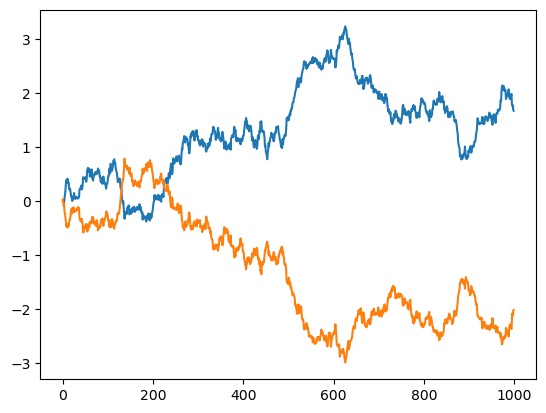

In [63]:
for path in CX:
    plt.plot(path.cumsum())

plt.savefig(f".\datasets\CorrelatedBrownian\\test.png")

### Binance - 3 USDT-based Assets

In [ ]:
from train import benchmark_sigwgan, benchmark_wgan

compute_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

target_dataset = ('MyBinance', )

training_generators = ('LogSigRNN',)
training_discriminators=('ResFNN',)

n_seeds = {
    "start": 0,
    "end": 1,
    "step": 5
}

benchmark_sigwgan(datasets=target_dataset,
                    generators=training_generators,
                    n_seeds=n_seeds,
                    device=compute_device)

benchmark_wgan(datasets=target_dataset,
                generators=training_generators,
                discriminators=training_discriminators,
                n_seeds=n_seeds,
                device=compute_device)


![alt text](./numerical_results/MyBinance/SigWGAN_LogSigRNN_0/comparison.png "Binance Result")

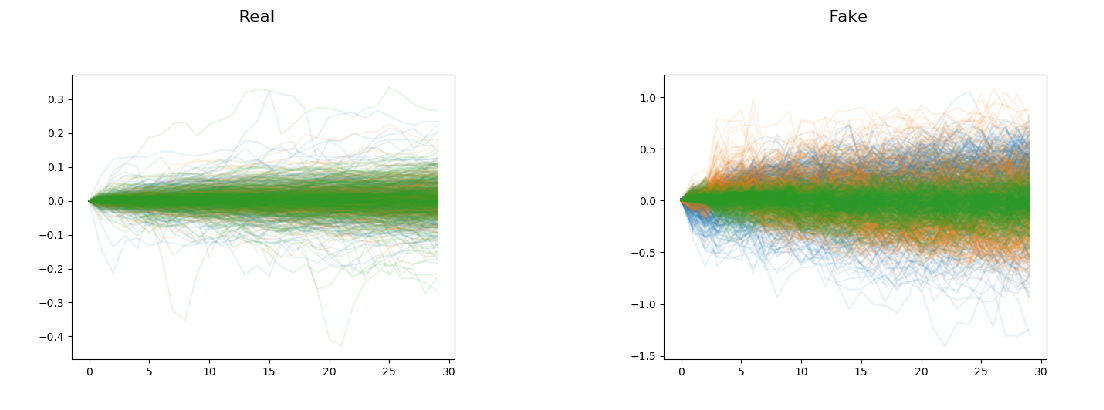

In [9]:
# Open the two PNG images
image1 = Image.open("./numerical_results/MyBinance/SigWGAN_LogSigRNN_0/x_real.png")
image2 = Image.open("./numerical_results/MyBinance/SigWGAN_LogSigRNN_0/x_fake.png")

# Create a new figure and display the images side by side
plt.figure(figsize=(14, 8))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)  # Subplot with 1 row and 2 columns, position 1
plt.imshow(image1)
plt.title("Real")
plt.axis('off')

plt.subplot(1, 2, 2)  # Subplot with 1 row and 2 columns, position 2
plt.imshow(image2)
plt.title("Fake")
plt.axis('off')

plt.show()